In [1]:
import matplotlib as mpl
from matplotlib import pyplot, gridspec
from matplotlib.ticker import MultipleLocator, NullFormatter, ScalarFormatter

from metpy import plots, calc
from metpy.units import units

import numpy as np

import pyart

import profile_io as io


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def plot_skewT(profile1, profile2, title,
                subplot_idx,
                fig,
                comp_pressure=None, comp_dewpoint=None, top_pressure=200,
                profile1_barb_skip=40, profile2_barb_skip=10,
                vert_dim='model_level_number', **kwargs):

    """
    Plot a skew T plot with optional profile.

    Arguments:
        - **kwargs: Optional extra arguments to cape_func or to metpy.plots.SkewT.
    """

    # New blank skew T plot.
    skew = plots.SkewT(fig, subplot=subplot_idx, **kwargs)

    # Plot environmental temperature.
    skew.plot(pressure = profile1['pres'], t = profile1['tmpc'], 
            color = 'r', linewidth = 1.2)
    skew.plot(pressure = profile2['pres'], t = profile2['tmpc'], 
            color = 'r', linewidth = 0.5)


    # Plot dewpoint.
    skew.plot(pressure = profile1['pres'], t = profile1['dwpc'],
            color = 'g', linewidth = 1.2)
    skew.plot(pressure = profile2['pres'], t = profile2['dwpc'],
            color = 'g', linewidth = 0.5)

    # Plot wind.
    skew.plot_barbs(pressure=profile1['pres'][::profile1_barb_skip],
                    u=profile1['wind_u'][::profile1_barb_skip],
                    v=profile1['wind_v'][::profile1_barb_skip],
                    xloc=0.80, y_clip_radius=0.01, linewidth = 1.2)

    skew.plot_barbs(pressure=profile2['pres'][::profile2_barb_skip],
                    u=profile2['wind_u'][::profile2_barb_skip],
                    v=profile2['wind_v'][::profile2_barb_skip],
                    xloc=0.92, y_clip_radius=0.01, linewidth = 0.5)                 

    # Add labels.
    pyplot.ylim(1050, top_pressure)
    pyplot.xlim(-30, 40)
    pyplot.xlabel('Temperature ($^{\circ}$C)')
    pyplot.ylabel('Pressure (hPa)')
    pyplot.title(title)

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


/home/jsoderho/miniconda3/envs/metpy/lib/python3.11/site-packages/metpy/calc/thermo.py:1384: RuntimeWarning: divide by zero encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)
/home/jsoderho/miniconda3/envs/metpy/lib/python3.11/site-packages/metpy/calc/thermo.py:1385: RuntimeWarning: invalid value encountered in divide
  return mpconsts.nounit.zero_degc + 243.5 * val / (17.67 - val)


0.8512103480026105
1.150524629640386
0.4733914576254358
0.6142203474137458
0.27996867609914594
1.0318819488116757
2.385680265220525
1.7972957046339453
0.513104947404419
0.39593285176943543
2.5900801253486434
2.359041963971919
1.3889586732719934
0.8221235115005093
0.7807577451505936
1.6909340106302637
2.201060994884908
1.3702947224779352
1.188200243101557
[6.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0. ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


(1050.0, 280.0)

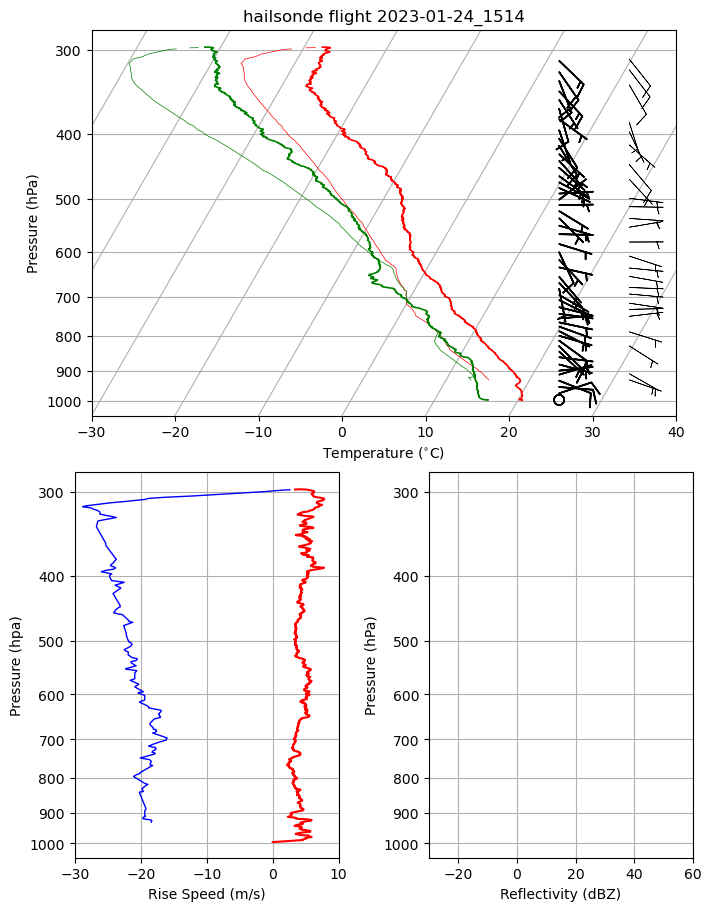

In [24]:
#read data
filename = 'test_data/hailsonde_2023-01-24_1514_8756.raw_flight_history.csv'
with_balloon_profile, no_balloon_profile, metadata = io.decode_raw_flight_history(filename, split=1998)
top_pressure = 280

#create figure and axes
fig = pyplot.figure(constrained_layout = True, figsize = (7, 9))
gs = fig.add_gridspec(2, 2)


#plot skewT profiles
plot_skewT(with_balloon_profile, no_balloon_profile,
                'hailsonde flight 2023-01-24_1514',
                subplot_idx=gs[0, :],
                fig=fig,
                top_pressure=top_pressure,
                vert_dim='altitude above MSL (m)')

#plot rise speed
ax1 = fig.add_subplot(gs[1, 0])
ax1.set_yscale('log')
ax1.yaxis.set_major_formatter(ScalarFormatter())
ax1.yaxis.set_major_locator(MultipleLocator(100))
ax1.yaxis.set_minor_formatter(NullFormatter())
ax1.plot(with_balloon_profile['rise'], with_balloon_profile['pres'], color='r', linewidth=1.5)
ax1.plot(no_balloon_profile['rise'], no_balloon_profile['pres'], color='b', linewidth=1)
ax1.set_xlabel('Rise Speed (m/s)')
ax1.set_ylabel('Pressure (hpa)')
ax1.grid()
ax1.set_xlim((-30,10))
ax1.set_ylim((1050,top_pressure))

#plot reflectivity profile
ax2 = fig.add_subplot(gs[1, 1])
ax2.set_yscale('log')
ax2.yaxis.set_major_formatter(ScalarFormatter())
ax2.yaxis.set_major_locator(MultipleLocator(100))
ax2.yaxis.set_minor_formatter(NullFormatter())

#define height levels
alt_refl_profile = np.arange(500,10000,500)

#init
pres_refl_profile1 = np.zeros_like(alt_refl_profile, dtype=float)
lat_refl_profile1 = np.zeros_like(alt_refl_profile, dtype=float)
lon_refl_profile1 = np.zeros_like(alt_refl_profile, dtype=float)
time_refl_profile1 = np.zeros_like(alt_refl_profile, dtype=float)
pres_refl_profile2 = np.zeros_like(alt_refl_profile, dtype=float)
lat_refl_profile2 = np.zeros_like(alt_refl_profile, dtype=float)
lon_refl_profile2 = np.zeros_like(alt_refl_profile, dtype=float)
time_refl_profile2 = np.zeros_like(alt_refl_profile, dtype=float)

#filter out nan values
nan_mask1 = np.isnan(with_balloon_profile['lat'])
filt_hght_profile1 = with_balloon_profile['hght'][~nan_mask1]
nan_mask2 = np.isnan(no_balloon_profile['lat'])
filt_hght_profile2 = no_balloon_profile['hght'][~nan_mask2]

#find nearest profile locations to height levels
for i, alt in enumerate(alt_refl_profile):
    idx = find_nearest_idx(filt_hght_profile1, alt)
    pres_refl_profile1[i] = np.array(with_balloon_profile['pres'])[~nan_mask1][idx]
    lat_refl_profile1[i] = np.array(with_balloon_profile['lat'])[~nan_mask1][idx]
    lon_refl_profile1[i] = np.array(with_balloon_profile['lon'])[~nan_mask1][idx]
    time_refl_profile1[i] = np.array(with_balloon_profile['time'])[~nan_mask1][idx]

    idx = find_nearest_idx(filt_hght_profile2, alt)
    pres_refl_profile2[i] = np.array(no_balloon_profile['pres'])[~nan_mask2][idx]
    lat_refl_profile2[i] = np.array(no_balloon_profile['lat'])[~nan_mask2][idx]
    lon_refl_profile2[i] = np.array(no_balloon_profile['lon'])[~nan_mask2][idx]
    time_refl_profile2[i] = np.array(no_balloon_profile['time'])[~nan_mask2][idx]

#for each time, load the closest radar volume and extract the closest radar pixel
radar = pyart.aux_io.read_odim_h5('test_data/2_20230123_042000.pvol.h5')
gate_lat = radar.gate_latitude['data']
gate_lon = radar.gate_longitude['data']
gate_alt = radar.gate_altitude['data']
gate_refl = radar.fields['reflectivity_horizontal']['data'].data


radar_refl_profile1 = np.zeros_like(alt_refl_profile, dtype=float)
radar_refl_profile2 = np.zeros_like(alt_refl_profile, dtype=float)
for i in range(len(alt_refl_profile)):
    dist = np.sqrt((gate_lat - lat_refl_profile1[i])**2 + (gate_lon - lon_refl_profile1[i])**2 + (gate_alt - alt_refl_profile[i])**2)
    min_dist_idx = np.unravel_index(np.abs(dist).argmin(), gate_refl.shape)
    radar_refl_profile1[i] = gate_refl[min_dist_idx]

    print(np.abs(dist).min())

    dist = np.sqrt((gate_lat - lat_refl_profile2[i])**2 + (gate_lon - lon_refl_profile2[i])**2 + (gate_alt - alt_refl_profile[i])**2)
    min_dist_idx = np.unravel_index(np.abs(dist).argmin(), gate_refl.shape)
    radar_refl_profile2[i] = gate_refl[min_dist_idx]  
    
print(radar_refl_profile1)
print(radar_refl_profile2)

ax2.set_xlabel('Reflectivity (dBZ)')
ax2.set_ylabel('Pressure (hPa)')
ax2.grid()
ax2.set_xlim((-30,60))
ax2.set_ylim((1050,top_pressure))


# pyplot.savefig(filename + '.png')